<a href="https://colab.research.google.com/github/nericovich/project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект для задачи Яндекс Лицея "Анализ экологических проблем"

### На заводе по производству полезного полимера ООО “Synthesising the future“ обратились за помощью в исследовании зависимостей вредных выбросов от производственных показателей. Требуется повести анализ данных и построить выводы о том, какой этап имеет высокий риск создать повышенное содержания вредного газа.


## Импорты

In [23]:
import pandas as pd
import seaborn as sns
from scipy.stats import mannwhitneyu, ttest_ind, shapiro

In [27]:
df = pd.read_csv('data.csv', sep=',', decimal='.', skipinitialspace=True)

## Main


### Обработка

In [9]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [29]:
df.head(4)

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,108.65,45.59,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2.0
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,108.71,45.89,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2.0
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,108.76,46.19,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2.0
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,108.63,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0


In [30]:
df.dtypes

DateTime                                 object
stage_1_output_konv_avd                 float64
stage_2_input_water_sum                 float64
stage_2_output_bottom_pressure          float64
stage_2_output_bottom_temp              float64
stage_2_output_bottom_temp_hum_steam    float64
stage_2_output_bottom_vacuum            float64
stage_2_output_top_pressure             float64
stage_2_output_top_pressure_at_end      float64
stage_2_output_top_temp                 float64
stage_2_output_top_vacuum               float64
stage_3_input_pressure                  float64
stage_3_input_soft_water                float64
stage_3_input_steam                     float64
stage_3_output_temp_hum_steam           float64
stage_3_output_temp_top                 float64
stage_4_input_overheated_steam          float64
stage_4_input_polymer                   float64
stage_4_input_steam                     float64
stage_4_input_water                     float64
stage_4_output_danger_gas               

In [31]:
df.isna().sum()

DateTime                                   0
stage_1_output_konv_avd                  241
stage_2_input_water_sum                  223
stage_2_output_bottom_pressure           220
stage_2_output_bottom_temp               191
stage_2_output_bottom_temp_hum_steam     177
stage_2_output_bottom_vacuum             231
stage_2_output_top_pressure              182
stage_2_output_top_pressure_at_end       174
stage_2_output_top_temp                  204
stage_2_output_top_vacuum                195
stage_3_input_pressure                   236
stage_3_input_soft_water                 213
stage_3_input_steam                      173
stage_3_output_temp_hum_steam            174
stage_3_output_temp_top                  230
stage_4_input_overheated_steam           169
stage_4_input_polymer                    226
stage_4_input_steam                      244
stage_4_input_water                      241
stage_4_output_danger_gas               3466
stage_4_output_dry_residue_avg           160
stage_4_ou

Надо что-то сделать со всеми, кроме stage_4_output_danger_gas

### Распределние

<Axes: xlabel='stage_1_output_konv_avd', ylabel='Density'>

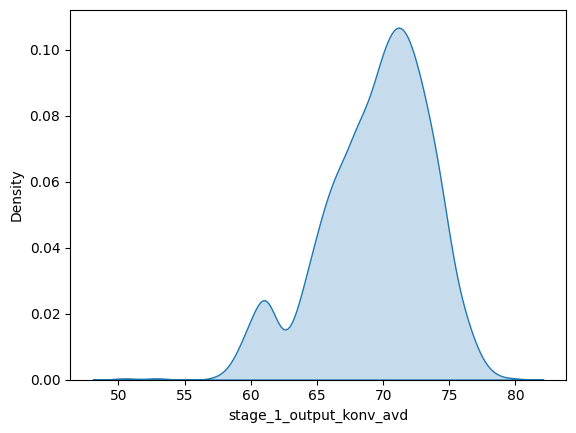

In [10]:
sns.kdeplot(data=df, x='stage_1_output_konv_avd', fill=True)

<Axes: xlabel='stage_2_input_water_sum', ylabel='Density'>

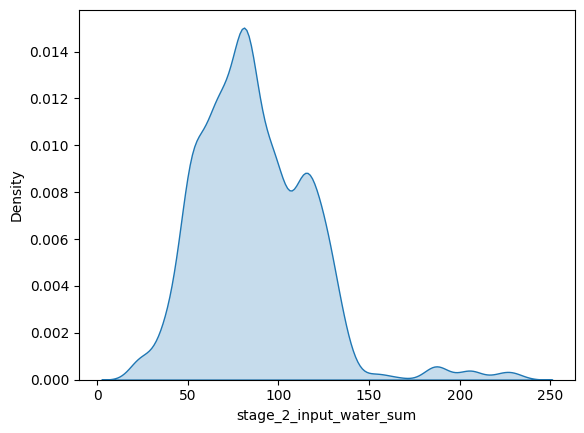

In [11]:
sns.kdeplot(data=df, x='stage_2_input_water_sum', fill=True)

<Axes: xlabel='stage_2_output_bottom_pressure', ylabel='Density'>

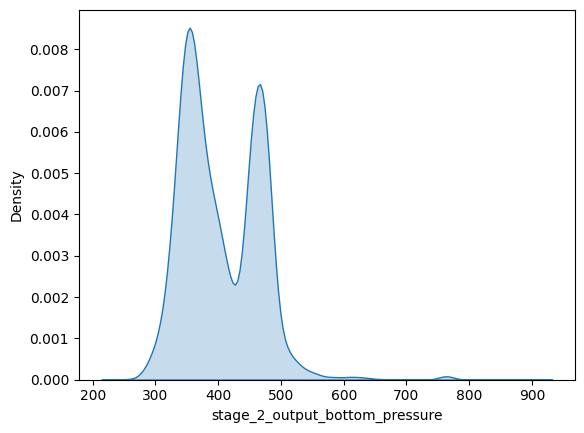

In [12]:
sns.kdeplot(data=df, x='stage_2_output_bottom_pressure', fill=True)

<Axes: xlabel='stage_2_output_bottom_temp', ylabel='Density'>

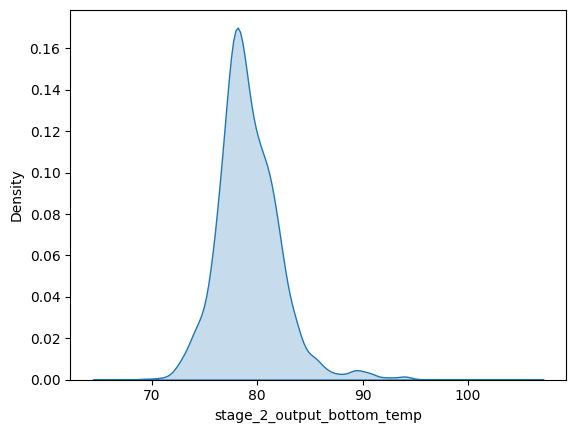

In [13]:
sns.kdeplot(data=df, x='stage_2_output_bottom_temp', fill=True)

<Axes: xlabel='stage_2_output_top_pressure', ylabel='Density'>

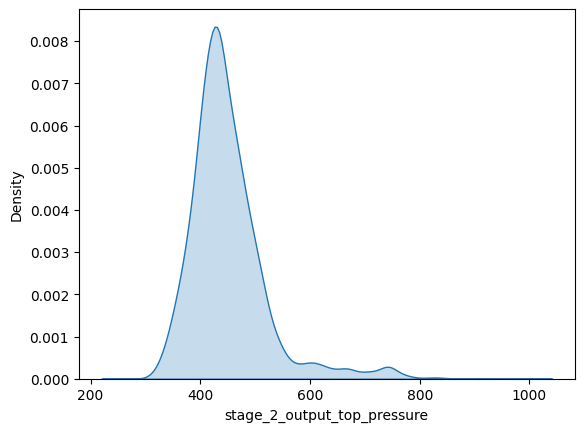

In [14]:
sns.kdeplot(data=df, x='stage_2_output_top_pressure', fill=True)

<Axes: xlabel='stage_2_output_top_pressure_at_end', ylabel='Density'>

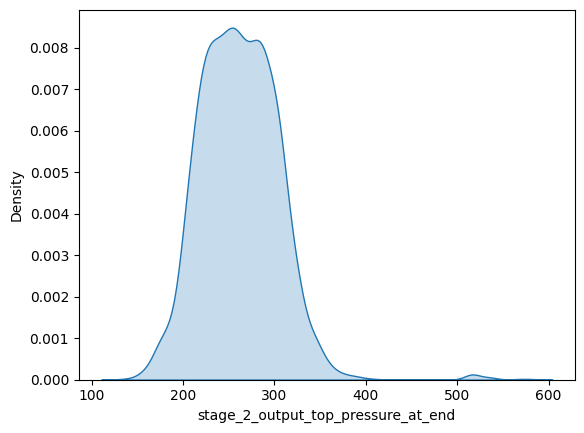

In [15]:
sns.kdeplot(data=df, x='stage_2_output_top_pressure_at_end', fill=True)

<Axes: xlabel='stage_3_input_pressure', ylabel='Density'>

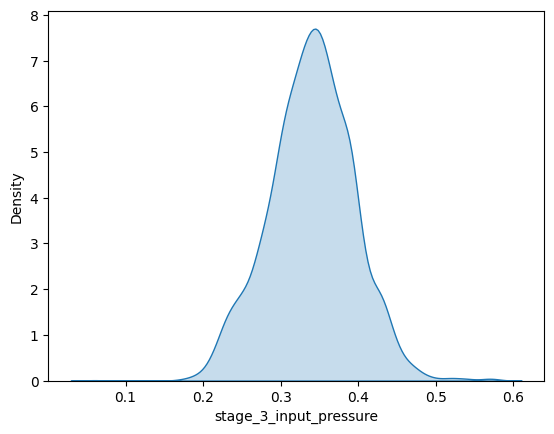

In [16]:
sns.kdeplot(data=df, x='stage_3_input_pressure', fill=True)

<Axes: xlabel='stage_3_output_temp_hum_steam', ylabel='Density'>

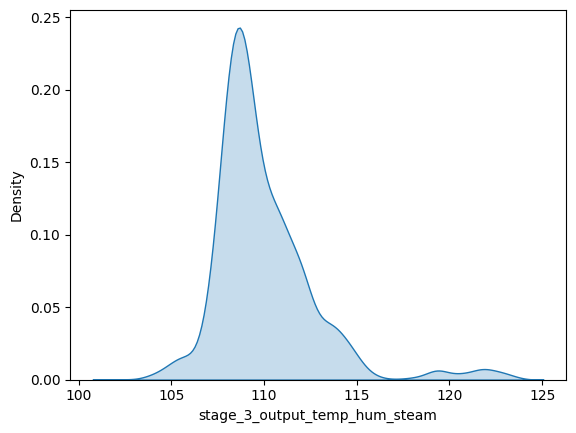

In [17]:
sns.kdeplot(data=df, x='stage_3_output_temp_hum_steam', fill=True)

<Axes: xlabel='stage_3_output_temp_top', ylabel='Density'>

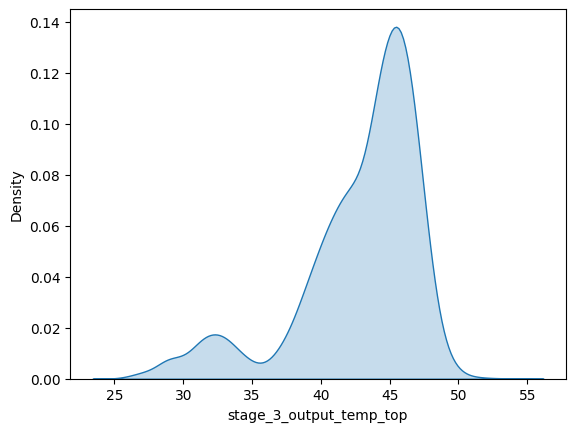

In [18]:
sns.kdeplot(data=df, x='stage_3_output_temp_top', fill=True)

<Axes: xlabel='stage_4_input_overheated_steam', ylabel='Density'>

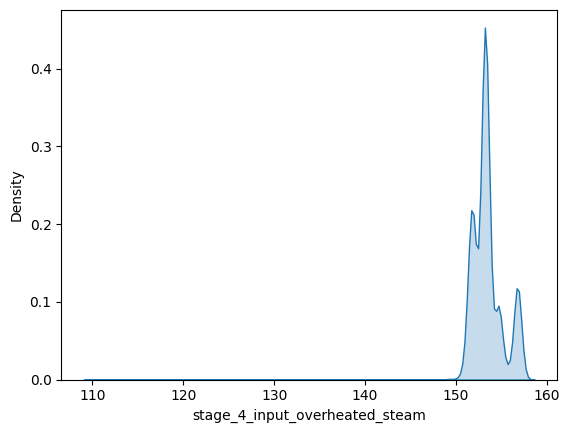

In [19]:
sns.kdeplot(data=df, x='stage_4_input_overheated_steam', fill=True)

<Axes: xlabel='stage_4_output_danger_gas', ylabel='Density'>

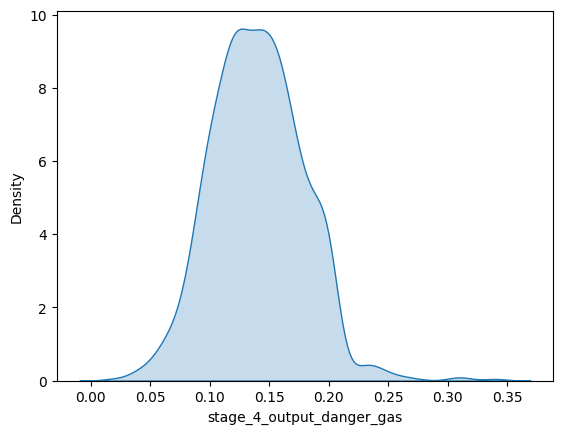

In [20]:
sns.kdeplot(data=df, x='stage_4_output_danger_gas', fill=True)

<Axes: xlabel='work_shift', ylabel='Density'>

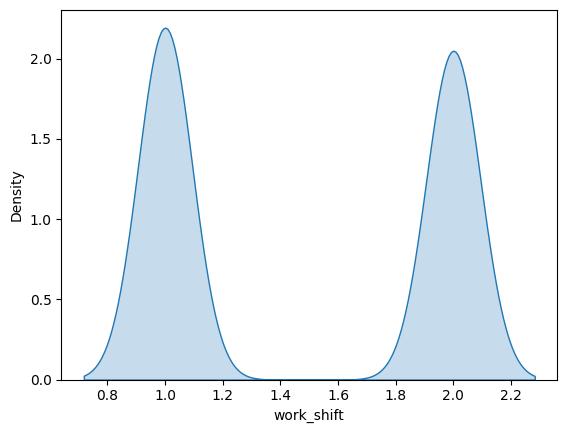

In [21]:
sns.kdeplot(data=df, x='work_shift', fill=True)

Факторы, распределение которых кажется нормальным:
* stage_2_output_bottom_temp
* stage_2_output_top_pressure
* stage_2_output_top_pressure_at_end
* stage_3_input_pressure
* stage_3_output_temp_hum_steam
* stage_3_output_temp_top
* stage_4_output_danger_gas

Факторы, которые требуется более деально посмотреть:
* work_shift
* stage_4_input_overheated_steam